In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
# from pyearth import Earth


In [2]:
data = pd.read_excel("owid-covid-data.xlsx")

In [3]:
# picking out our 10 countries that have relatively low missingness and that are adjacent 
country_list = [
    'Norway', 'Finland', 'Lithuania', 'Ireland', 'United Kingdom',
    'Italy', 'Belgium', 'Denmark', 'Switzerland', 'Poland'
]
selected_data = data[data['location'].isin(country_list)]
selected_data.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
28497,BEL,Europe,Belgium,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28498,BEL,Europe,Belgium,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28499,BEL,Europe,Belgium,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,-151.3,-6.34,-6.34,-13.086293
28500,BEL,Europe,Belgium,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28501,BEL,Europe,Belgium,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN


## Data Prep

### Removing irrelevant dates


Dates to remove specified in ARIMA file.

In [4]:
# Subset the dataset
data_clean = selected_data[(selected_data['date'] >= '2020-03-01') & (selected_data['date'] <= '2023-01-15')]

In [5]:
# check missingness
missing_values_count = data_clean['new_cases'].isnull().sum()
print(missing_values_count)

0


### Removing variables

#### Dropping more than 30% missingness

In [6]:

# create a table that shows the number of features with more than 30% missing values for each country
def missing_features_by_country(df):

    missingness = df.groupby('location').apply(lambda group: group.isna().mean() * 100)
    
    # Count the number of features with more than 30% missing values for each country
    features_missing_40 = (missingness > 40).sum(axis=1)
    
    # Create a summary DataFrame
    summary = pd.DataFrame({
        'Country': features_missing_40.index,
        'Features with >40% Missingness': features_missing_40.values
    })
    
    return summary.sort_values(by='Features with >40% Missingness', ascending=True)

# Calculate and display the results
missing_features_summary = missing_features_by_country(data_clean)
print(missing_features_summary)

          Country  Features with >40% Missingness
4           Italy                               7
0         Belgium                               9
8     Switzerland                              10
5       Lithuania                              13
6          Norway                              13
3         Ireland                              15
1         Denmark                              16
2         Finland                              19
7          Poland                              19
9  United Kingdom                              20


In [7]:
#data missingness
missing_data = data_clean.isnull().sum()
threshold = 0.3 * len(data_clean)
missing_data = missing_data[missing_data < threshold]
missing_data

iso_code                              0
continent                             0
location                              0
date                                  0
total_cases                          25
new_cases                             0
new_cases_smoothed                    0
total_deaths                         81
new_deaths                            0
new_deaths_smoothed                   0
total_cases_per_million              25
new_cases_per_million                 0
new_cases_smoothed_per_million        0
total_deaths_per_million             81
new_deaths_per_million                0
new_deaths_smoothed_per_million       0
reproduction_rate                   223
hosp_patients                      2499
hosp_patients_per_million          2499
total_tests                        3023
new_tests                          3146
total_tests_per_thousand           3023
new_tests_per_thousand             3146
new_tests_smoothed                 2365
new_tests_smoothed_per_thousand    2365


In [8]:
# drop features with >30% missingness
threshold = 0.7 * len(selected_data)

data_clean = data_clean.dropna(thresh=threshold, axis=1)
data_clean.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')

#### Removing constants

In [9]:

# Assuming 'df' is your DataFrame
df_grouped = data_clean.groupby('location')

threshold = 0.95

# For each location after grouping
constant_columns_by_location = df_grouped.apply(lambda group: group.columns[group.apply(lambda col: col.value_counts(normalize=True).max() >= threshold)])

constant_columns_df = constant_columns_by_location.reset_index(name='cons_variables')


print(constant_columns_df['cons_variables'].iloc[0])

Index(['iso_code', 'continent', 'location', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')


Constant Variables:

['iso_code', 'continent', 'location', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population']

Keeping location though!

In [10]:
variables_to_remove = ['iso_code', 'continent', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population']

data_clean_subset = data_clean.drop(columns=variables_to_remove)
data_clean_subset.columns



Index(['location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed',
       'total_deaths', 'new_deaths', 'new_deaths_smoothed',
       'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'reproduction_rate', 'stringency_index'],
      dtype='object')

Still need to remove all the totals and smoothers: 'total_cases', 'total_deaths', 'new_cases_smoothed', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million'

In [11]:
remove = ['total_cases', 'total_deaths', 'new_cases_smoothed', 'new_deaths_smoothed', 
          'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 
          'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million']

data_clean_subset = data_clean_subset.drop(columns=remove)
data_clean_subset.columns


Index(['location', 'date', 'new_cases', 'new_deaths', 'reproduction_rate',
       'stringency_index'],
      dtype='object')

In [13]:
data_clean_subset.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index
date,,,,,
2020-03-01,Belgium,0.0,0.0,NaN,11.11
2020-03-02,Belgium,0.0,0.0,NaN,11.11
2020-03-03,Belgium,18.0,0.0,NaN,11.11
2020-03-04,Belgium,19.0,0.0,NaN,13.89
2020-03-05,Belgium,34.0,0.0,NaN,13.89


#### Testing for Multicollinearity

In [12]:
## date as index
# Convert 'ds' to datetime if it's not already

data_clean_subset['date'] = pd.to_datetime(data_clean['date'])

data_clean_subset.set_index('date', inplace=True)

In [14]:
data_clean_subset.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index
date,,,,,
2020-03-01,Belgium,0.0,0.0,NaN,11.11
2020-03-02,Belgium,0.0,0.0,NaN,11.11
2020-03-03,Belgium,18.0,0.0,NaN,11.11
2020-03-04,Belgium,19.0,0.0,NaN,13.89
2020-03-05,Belgium,34.0,0.0,NaN,13.89


<Axes: >

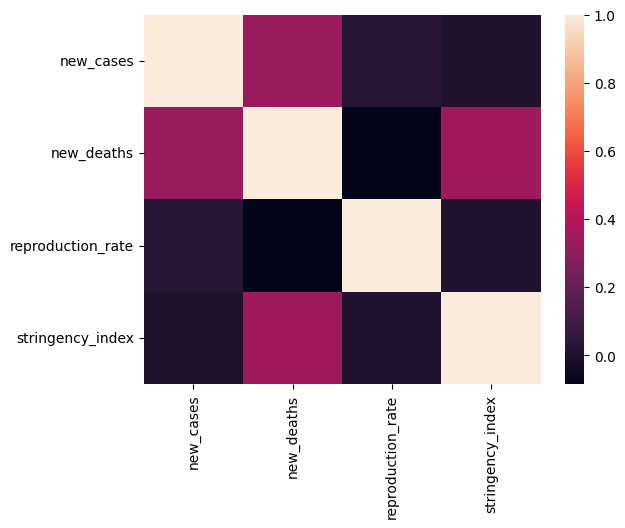

In [15]:
for_corr = data_clean_subset.copy().drop(columns=['location'])
correlation = for_corr.corr( method='pearson' )
sns.heatmap( correlation )

Pretty good on collinearity, can move forward with these variables.

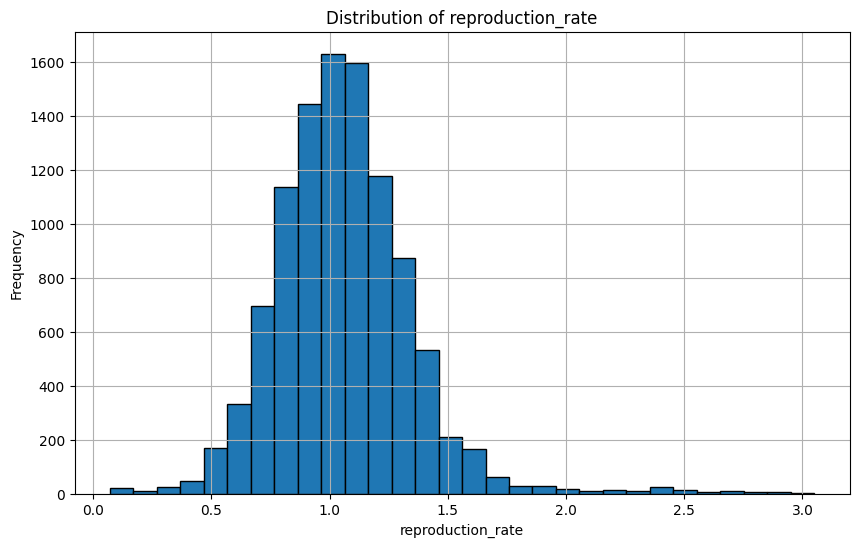

In [18]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'data_clean_no_outliers' and the column is 'your_column_name'
column_to_plot = 'reproduction_rate'

# Plotting the distribution
plt.figure(figsize=(10, 6))
data_clean_subset[column_to_plot].hist(bins=30, edgecolor='black')
plt.title(f'Distribution of {column_to_plot}')
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')
plt.show()

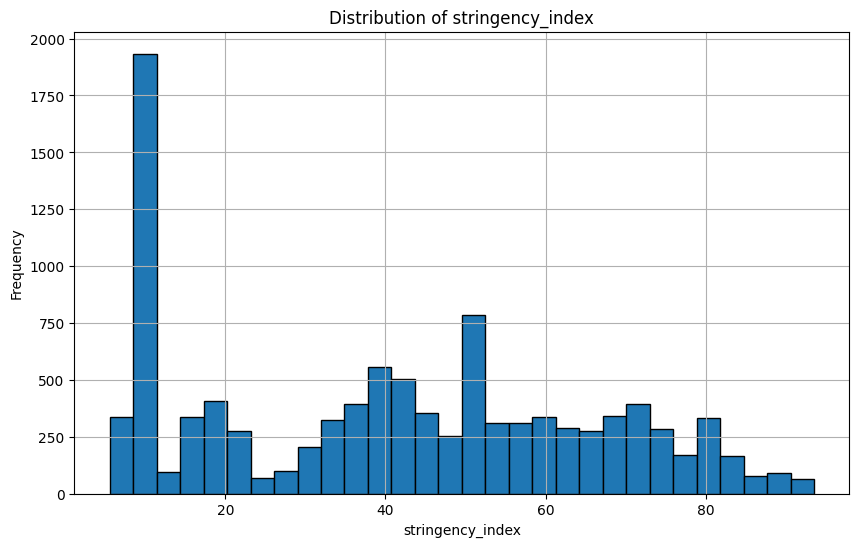

In [19]:
# Assuming your DataFrame is named 'data_clean_no_outliers' and the column is 'your_column_name'
column_to_plot = 'stringency_index'

# Plotting the distribution
plt.figure(figsize=(10, 6))
data_clean_subset[column_to_plot].hist(bins=30, edgecolor='black')
plt.title(f'Distribution of {column_to_plot}')
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')
plt.show()

#### Dealing with Outliers

In [20]:
data_clean_subset.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index
date,,,,,
2020-03-01,Belgium,0.0,0.0,NaN,11.11
2020-03-02,Belgium,0.0,0.0,NaN,11.11
2020-03-03,Belgium,18.0,0.0,NaN,11.11
2020-03-04,Belgium,19.0,0.0,NaN,13.89
2020-03-05,Belgium,34.0,0.0,NaN,13.89


In [21]:
na_counts = data_clean_subset.isna().sum()
print(na_counts)

location               0
new_cases              0
new_deaths             0
reproduction_rate    223
stringency_index     150
dtype: int64


In [16]:
from scipy import stats
import numpy as np

# Select only numeric columns
numeric_columns = data_clean_subset.select_dtypes(include='number')

# Calculate z-scores for each numeric column
z_scores = np.abs(stats.zscore(numeric_columns))

# Define a threshold for outlier detection
threshold = 3

# Replace outliers in numeric columns with NaN
data_clean_no_outliers = data_clean_subset.copy()
data_clean_no_outliers[numeric_columns.columns] = np.where(z_scores >= threshold, np.nan, data_clean_subset[numeric_columns.columns])

data_clean_no_outliers.head()



,location,new_cases,new_deaths,reproduction_rate,stringency_index
date,,,,,
2020-03-01,Belgium,0.0,0.0,NaN,11.11
2020-03-02,Belgium,0.0,0.0,NaN,11.11
2020-03-03,Belgium,18.0,0.0,NaN,11.11
2020-03-04,Belgium,19.0,0.0,NaN,13.89
2020-03-05,Belgium,34.0,0.0,NaN,13.89


In [17]:
na_counts = data_clean_no_outliers.isna().sum()
print(na_counts)

location               0
new_cases            199
new_deaths           283
reproduction_rate    223
stringency_index     150
dtype: int64


I want to use forward fill to impute new_cases and new_deaths, and impute the other two with the mean

In [18]:
# Forward fill new_cases and new_deaths
data_clean_no_outliers['new_cases'].fillna(method='ffill', inplace=True)
data_clean_no_outliers['new_deaths'].fillna(method='ffill', inplace=True)

# Impute reproduction_rate and stringency_index with mean
grouped_means = data_clean_no_outliers.groupby('location')[['reproduction_rate', 'stringency_index']].mean()

# Fill missing values based on the mean of each location
data_clean_no_outliers = data_clean_no_outliers.join(grouped_means, on='location', rsuffix='_mean')
data_clean_no_outliers['reproduction_rate'].fillna(data_clean_no_outliers['reproduction_rate_mean'], inplace=True)
data_clean_no_outliers['stringency_index'].fillna(data_clean_no_outliers['stringency_index_mean'], inplace=True)

# Drop the temporary columns used for filling missing values
data_clean_no_outliers.drop(['reproduction_rate_mean', 'stringency_index_mean'], axis=1, inplace=True)

/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1998/2874557633.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean_no_outliers['new_cases'].fillna(method='ffill', inplace=True)
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1998/2874557633.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean_no_outliers['new_deaths'].fillna(method='ffill', inplace=True)


In [19]:
data_clean_no_outliers.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index
date,,,,,
2020-03-01,Belgium,0.0,0.0,1.12314,11.11
2020-03-02,Belgium,0.0,0.0,1.12314,11.11
2020-03-03,Belgium,18.0,0.0,1.12314,11.11
2020-03-04,Belgium,19.0,0.0,1.12314,13.89
2020-03-05,Belgium,34.0,0.0,1.12314,13.89


## Feature Engineering

### Creating Lag Features

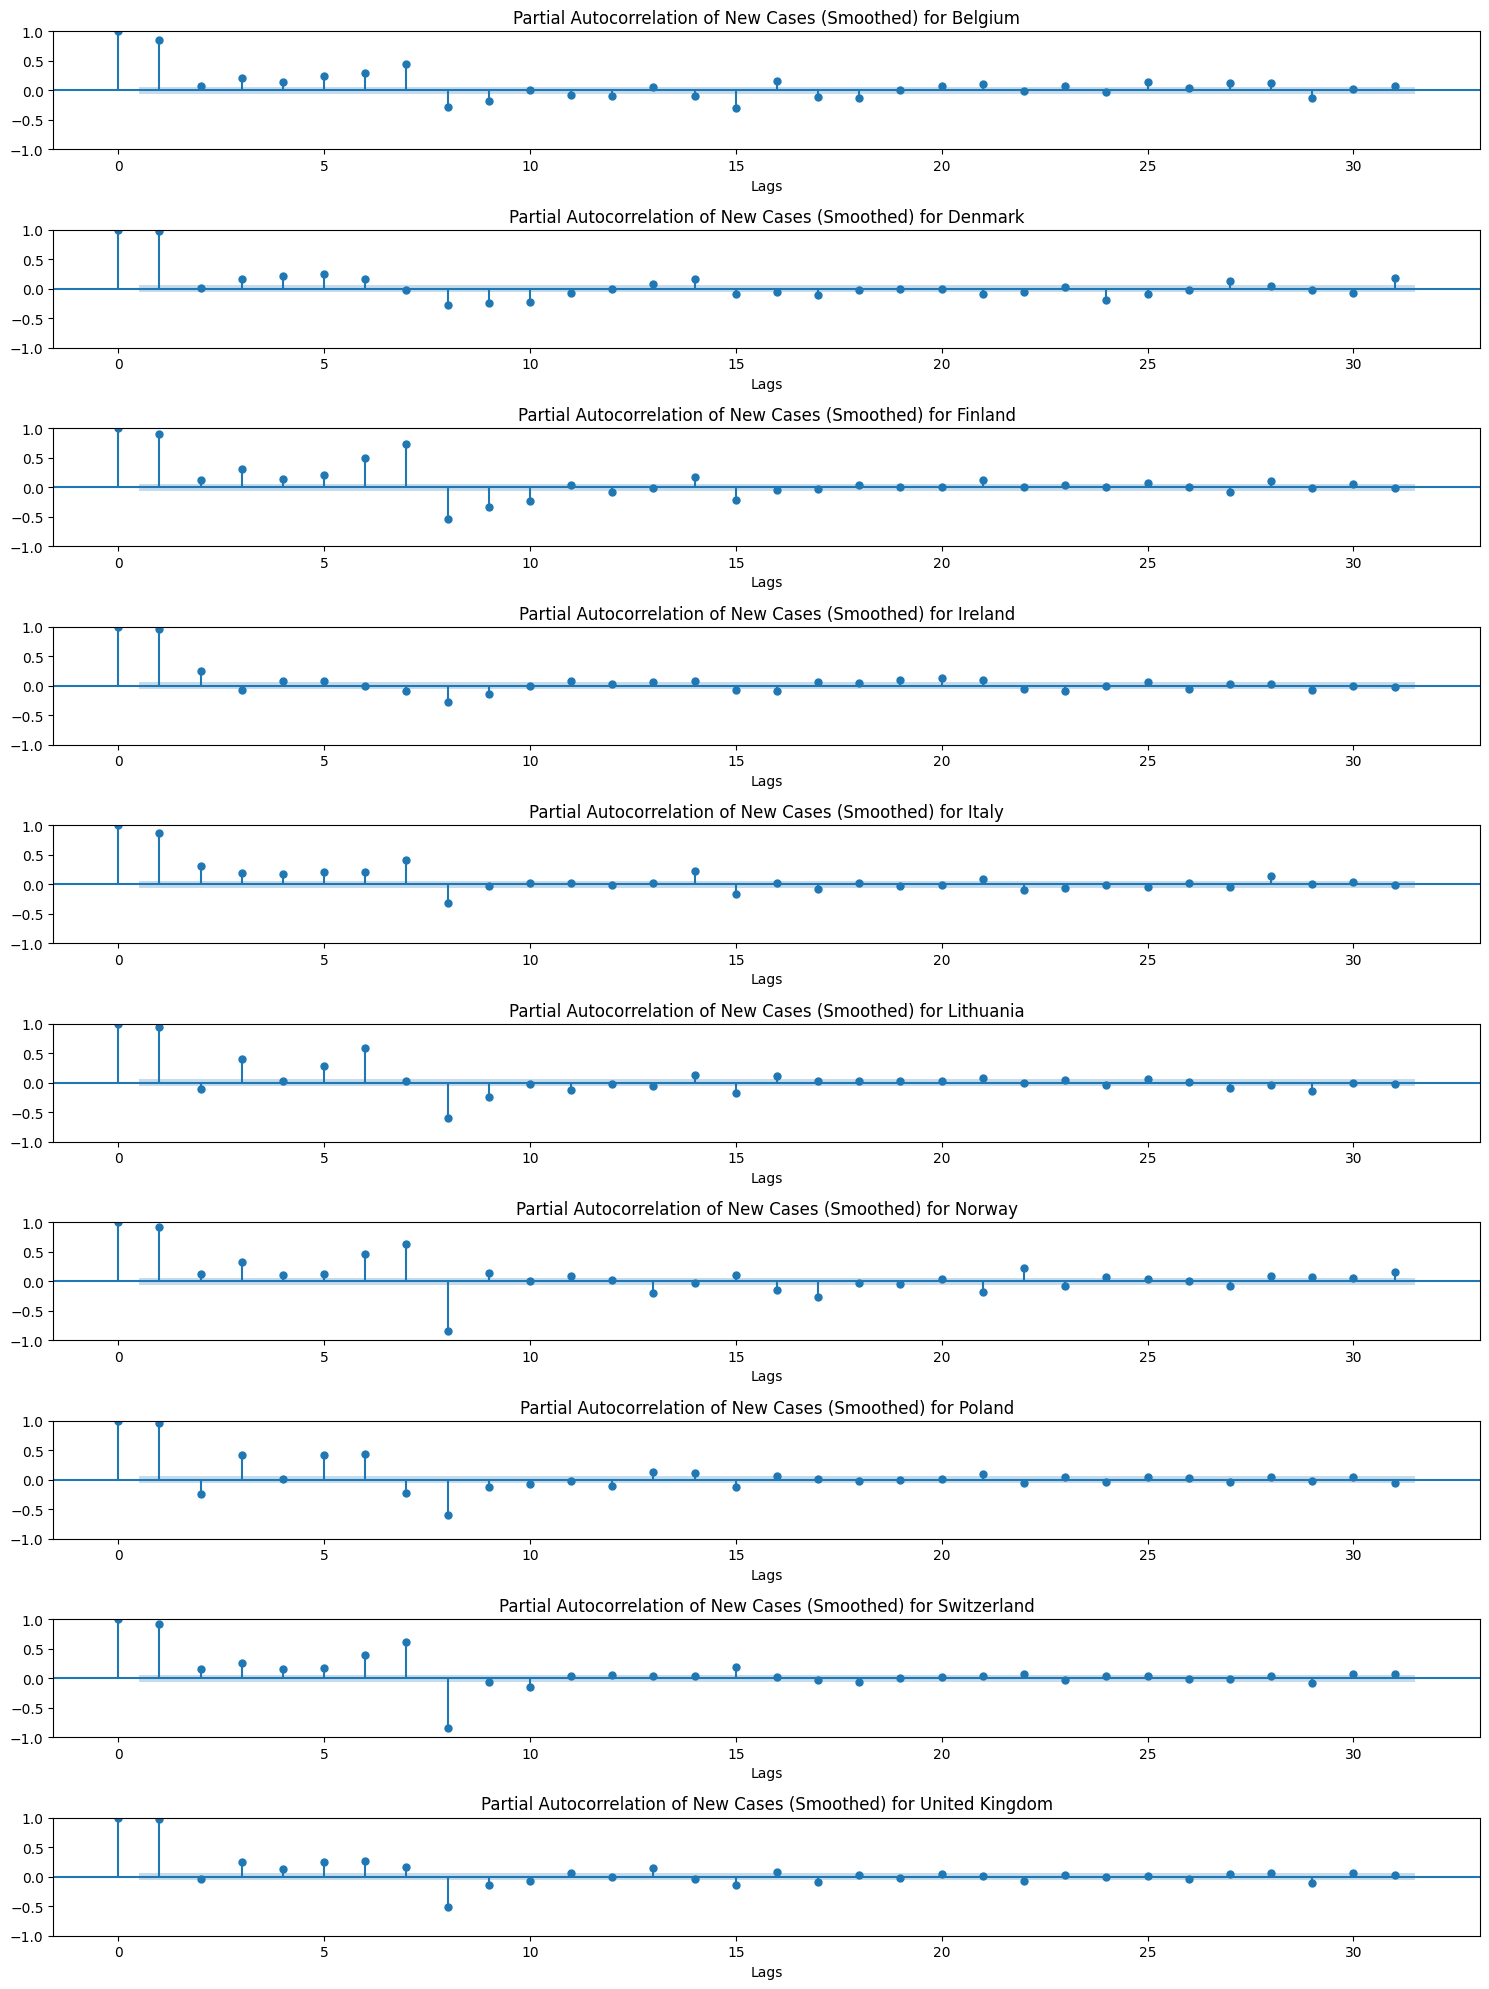

In [20]:
### Examining PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

countries = data_clean_no_outliers['location'].unique()

plt.figure(figsize=(15, 20))

for i, country in enumerate(countries, 1):
    plt.subplot(len(countries), 1, i)
    country_data = data_clean_no_outliers[data_clean_no_outliers['location'] == country]['new_cases']
    plot_pacf(country_data.dropna(), alpha=0.05, ax=plt.gca())
    plt.title(f'Partial Autocorrelation of New Cases (Smoothed) for {country}')
    plt.xlabel('Lags')

plt.tight_layout()
plt.show()

Spikes at lags 1 and 8, adding lags at 1 and 8.

In [21]:
data_clean_lag = data_clean_no_outliers.copy()

for lag in [1, 8]:
    data_clean_lag[f'new_cases_lag{lag}'] = data_clean_lag['new_cases'].shift(lag)

data_clean_lag.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8
date,,,,,,,
2020-03-01,Belgium,0.0,0.0,1.12314,11.11,NaN,NaN
2020-03-02,Belgium,0.0,0.0,1.12314,11.11,0.0,NaN
2020-03-03,Belgium,18.0,0.0,1.12314,11.11,0.0,NaN
2020-03-04,Belgium,19.0,0.0,1.12314,13.89,18.0,NaN
2020-03-05,Belgium,34.0,0.0,1.12314,13.89,19.0,NaN


### Creating Rolling Mean Features

In [22]:
data_clean_roll_mean = data_clean_lag.copy()
# rolling window 7-day and 14-day for new_cases
for window in [7, 14]:
    data_clean_roll_mean[f'new_cases_roll_mean{window}'] = data_clean_roll_mean['new_cases'].rolling(window=window).mean()
    data_clean_roll_mean[f'new_cases_roll_std{window}'] = data_clean_roll_mean['new_cases'].rolling(window=window).std()

data_clean_roll_mean.head(10)

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14
date,,,,,,,,,,,
2020-03-01,Belgium,0.0,0.0,1.12314,11.11,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,Belgium,0.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-03,Belgium,18.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-04,Belgium,19.0,0.0,1.12314,13.89,18.0,NaN,NaN,NaN,NaN,NaN
2020-03-05,Belgium,34.0,0.0,1.12314,13.89,19.0,NaN,NaN,NaN,NaN,NaN
2020-03-06,Belgium,53.0,0.0,1.12314,13.89,34.0,NaN,NaN,NaN,NaN,NaN
2020-03-07,Belgium,81.0,0.0,2.43000,13.89,53.0,NaN,29.285714,29.460223,NaN,NaN
2020-03-08,Belgium,110.0,0.0,2.41000,13.89,81.0,NaN,45.000000,39.021362,NaN,NaN
2020-03-09,Belgium,27.0,1.0,2.41000,13.89,110.0,0.0,48.857143,34.954392,NaN,NaN


### Creating Time Features

#### Holidays and Seasons

In [23]:
import holidays

## changing date back to column
data_add_time = data_clean_roll_mean.reset_index()
data_add_time['date'] = pd.to_datetime(data_add_time['date'])

# Define the country for which you want to check holidays (e.g., 'US' for United States)
country_code = 'US'

# Get the list of holidays for the specified country
holiday_list = holidays.UnitedStates(years=data_add_time['date'].dt.year)

# Create a new column 'is_holiday' and set the values based on whether the date is a holiday or not
data_add_time['is_holiday'] = data_add_time['date'].isin(holiday_list).astype(int)
# Add a new column 'is_holiday' based on whether the date is a holiday
data_add_time.head(20)



,date,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,is_holiday
0,2020-03-01,Belgium,0.0,0.0,1.12314,11.11,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2020-03-02,Belgium,0.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN,0
2,2020-03-03,Belgium,18.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN,0
3,2020-03-04,Belgium,19.0,0.0,1.12314,13.89,18.0,NaN,NaN,NaN,NaN,NaN,0
4,2020-03-05,Belgium,34.0,0.0,1.12314,13.89,19.0,NaN,NaN,NaN,NaN,NaN,0
5,2020-03-06,Belgium,53.0,0.0,1.12314,13.89,34.0,NaN,NaN,NaN,NaN,NaN,0
6,2020-03-07,Belgium,81.0,0.0,2.43000,13.89,53.0,NaN,29.285714,29.460223,NaN,NaN,0
7,2020-03-08,Belgium,110.0,0.0,2.41000,13.89,81.0,NaN,45.000000,39.021362,NaN,NaN,0
8,2020-03-09,Belgium,27.0,1.0,2.41000,13.89,110.0,0.0,48.857143,34.954392,NaN,NaN,0
9,2020-03-10,Belgium,64.0,0.0,2.40000,19.44,27.0,0.0,55.428571,32.418396,NaN,NaN,0


In [24]:
holiday_count = data_add_time['is_holiday'].eq(1).sum()
holiday_list

{datetime.date(2020, 1, 20): 'Martin Luther King Jr. Day', datetime.date(2020, 2, 17): "Washington's Birthday", datetime.date(2020, 10, 12): 'Columbus Day', datetime.date(2020, 1, 1): "New Year's Day", datetime.date(2020, 5, 25): 'Memorial Day', datetime.date(2020, 7, 4): 'Independence Day', datetime.date(2020, 7, 3): 'Independence Day (Observed)', datetime.date(2020, 9, 7): 'Labor Day', datetime.date(2020, 11, 11): 'Veterans Day', datetime.date(2020, 11, 26): 'Thanksgiving', datetime.date(2020, 12, 25): 'Christmas Day', datetime.date(2021, 1, 18): 'Martin Luther King Jr. Day', datetime.date(2021, 2, 15): "Washington's Birthday", datetime.date(2021, 10, 11): 'Columbus Day', datetime.date(2021, 1, 1): "New Year's Day", datetime.date(2021, 12, 31): "New Year's Day (Observed)", datetime.date(2021, 5, 31): 'Memorial Day', datetime.date(2021, 6, 19): 'Juneteenth National Independence Day', datetime.date(2021, 6, 18): 'Juneteenth National Independence Day (Observed)', datetime.date(2021, 7, 

In [25]:
## seasons
data_add_time['season'] = data_add_time['date'].apply(lambda x: 'Winter' if x.month == 12 or x.month == 1
                                                      or x.month == 2 else 'Spring' if x.month == 3 or 
                                                      x.month == 4 or x.month == 5 else 'Summer' if x.month == 6
                                                      or x.month == 7 or x.month == 8 else 'Autumn' if x.month == 9
                                                      or x.month == 10 or x.month == 11 else '')

data_add_time.head()

,date,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,is_holiday,season
0,2020-03-01,Belgium,0.0,0.0,1.12314,11.11,NaN,NaN,NaN,NaN,NaN,NaN,0,Spring
1,2020-03-02,Belgium,0.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN,0,Spring
2,2020-03-03,Belgium,18.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN,0,Spring
3,2020-03-04,Belgium,19.0,0.0,1.12314,13.89,18.0,NaN,NaN,NaN,NaN,NaN,0,Spring
4,2020-03-05,Belgium,34.0,0.0,1.12314,13.89,19.0,NaN,NaN,NaN,NaN,NaN,0,Spring


#### Day of Week and Weekends

In [26]:
data_add_time.set_index('date', inplace = True)
data_add_time['day_of_week'] = data_add_time.index.dayofweek

data_add_time['weekend'] = np.where(data_add_time['day_of_week'].isin([5, 6]), 1, 0)
data_add_time['month'] = data_add_time.index.month
data_add_time['year'] = data_add_time.index.year
data_add_time['quarter'] = data_add_time.index.quarter
data_add_time['dayofyear'] = data_add_time.index.dayofyear
data_add_time['dayofmonth'] = data_add_time.index.day

In [27]:
data_add_time.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,is_holiday,season,day_of_week,weekend,month,year,quarter,dayofyear,dayofmonth
date,,,,,,,,,,,,,,,,,,,,
2020-03-01,Belgium,0.0,0.0,1.12314,11.11,NaN,NaN,NaN,NaN,NaN,NaN,0,Spring,6,1,3,2020,1,61,1
2020-03-02,Belgium,0.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN,0,Spring,0,0,3,2020,1,62,2
2020-03-03,Belgium,18.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN,0,Spring,1,0,3,2020,1,63,3
2020-03-04,Belgium,19.0,0.0,1.12314,13.89,18.0,NaN,NaN,NaN,NaN,NaN,0,Spring,2,0,3,2020,1,64,4
2020-03-05,Belgium,34.0,0.0,1.12314,13.89,19.0,NaN,NaN,NaN,NaN,NaN,0,Spring,3,0,3,2020,1,65,5


## Tuning Hyper Params

Number of trees (n_estimators)

Depth of each tree (max_depth)

Learning rate (learning_rate)

Sampling observations / predictors (subsample for observations, colsample_bytree for predictors)

Regularization parameters (reg_lambda & gamma)

In [28]:
data_prepped = data_add_time.copy()

In [29]:
location_counts = data_prepped['location'].value_counts()

print("Number of observations for each location:")
print(location_counts)

Number of observations for each location:
location
Belgium           1051
Denmark           1051
Finland           1051
Ireland           1051
Italy             1051
Lithuania         1051
Norway            1051
Poland            1051
Switzerland       1051
United Kingdom    1051
Name: count, dtype: int64


In [30]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame data_prepped with a 'new_cases' column and other features
# Make sure 'date' is set as the index

# Define features and target variable
X = data_prepped.drop('new_cases', axis=1)
y = data_prepped['new_cases']

# Encode categorical columns
X_encoded = pd.get_dummies(X, columns=['location', 'season'])

# Split the data into training and testing sets with a time-based split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.01332065, shuffle=False)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_lambda': [0, 1, 10],
    'gamma': [0, 0.1, 0.2],
}

# Create an XGBoost regressor
xgb_model = XGBRegressor()

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Initialize GridSearchCV with scoring as 'neg_root_mean_squared_error'
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=tscv, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Best parameters: {best_params}")
print(f"Root Mean Squared Error on test set: {rmse}\n")


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 0, 'subsample': 1.0}
Root Mean Squared Error on test set: 958.2859160391743



{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 0, 'subsample': 1.0}

Original Unique Locations: ['Belgium' 'Denmark' 'Finland' 'Ireland' 'Italy' 'Lithuania' 'Norway'
 'Poland' 'Switzerland' 'United Kingdom']


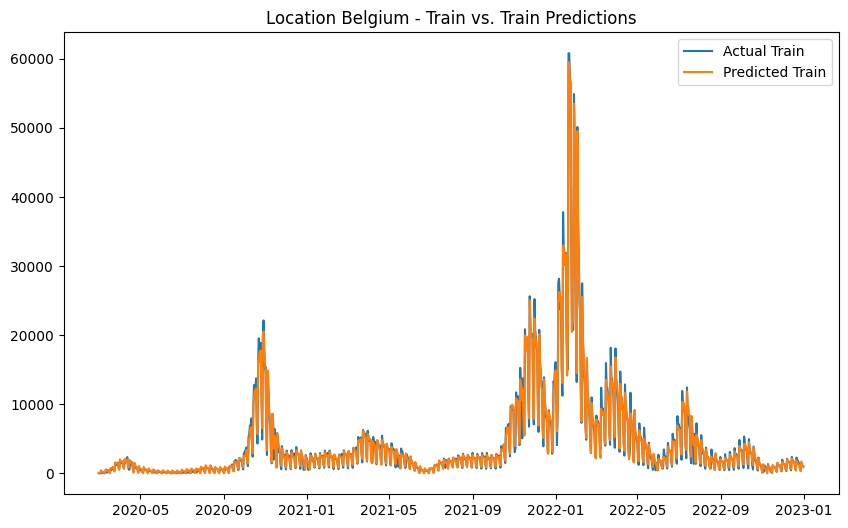

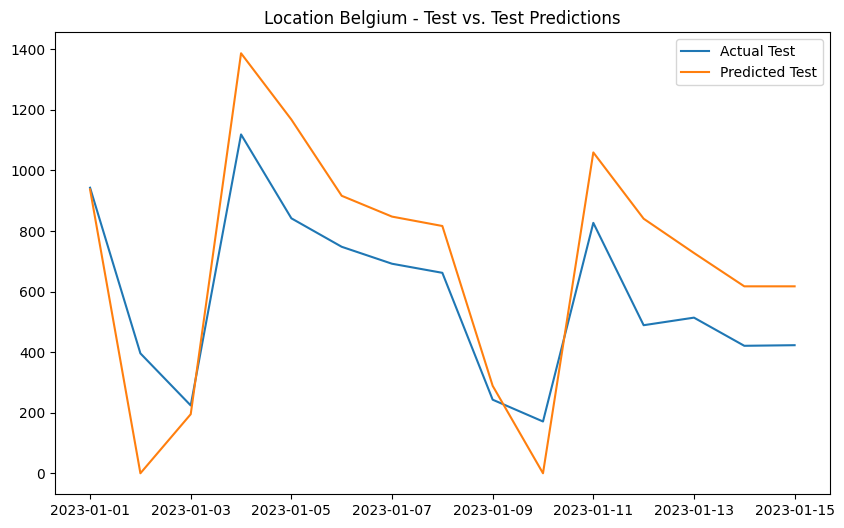

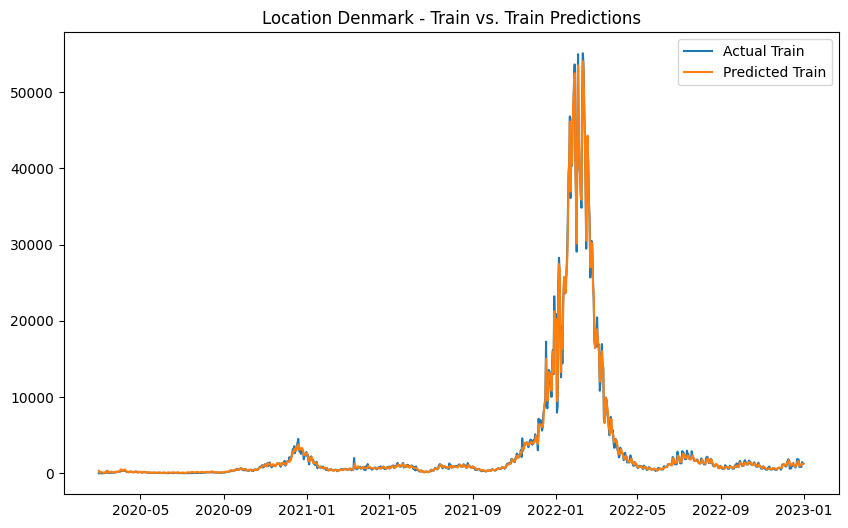

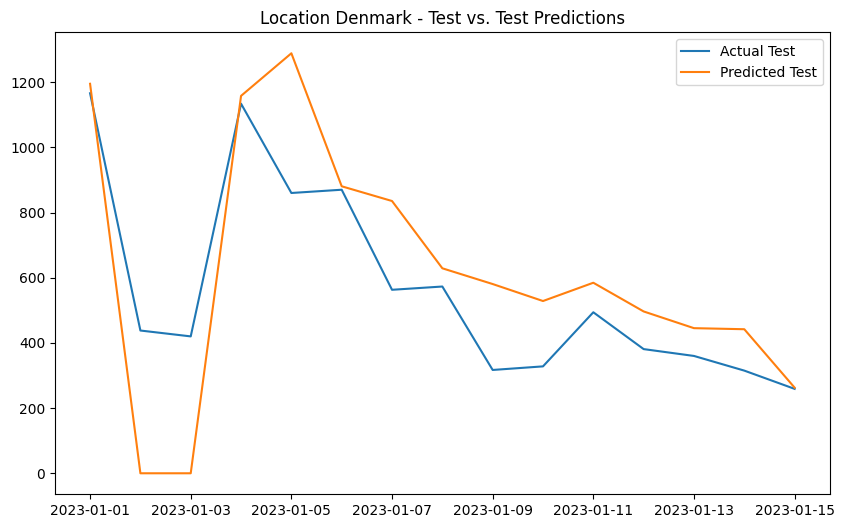

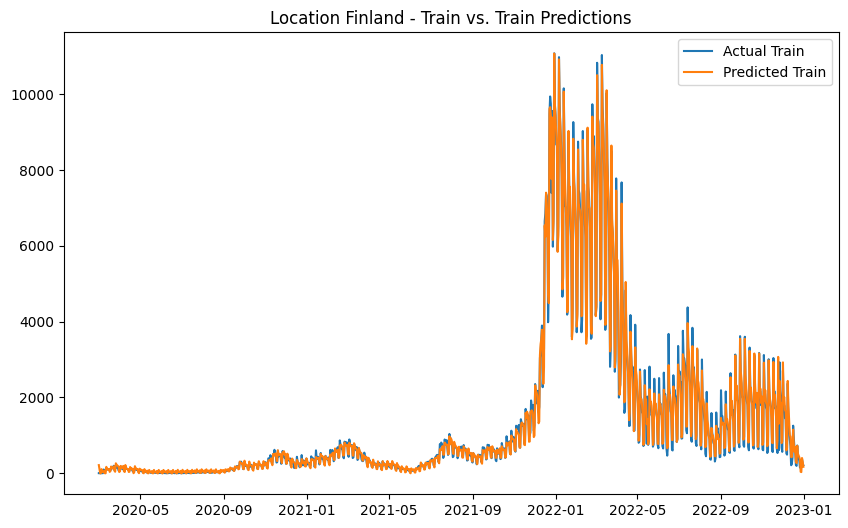

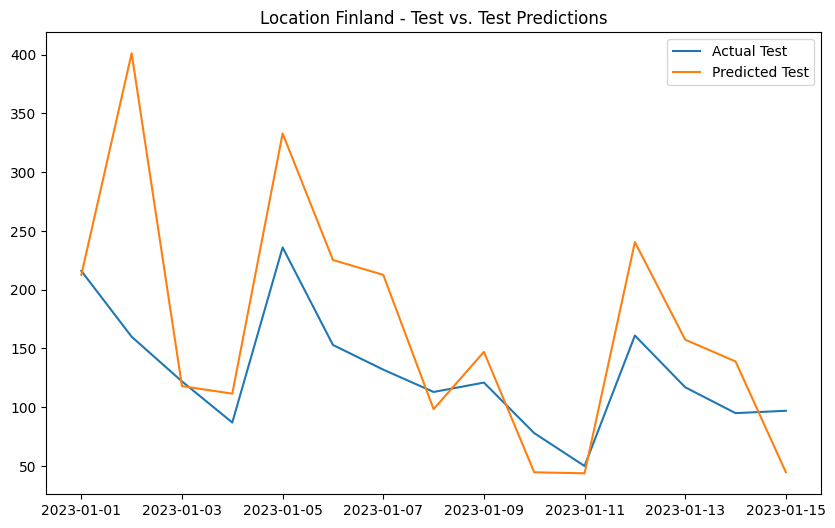

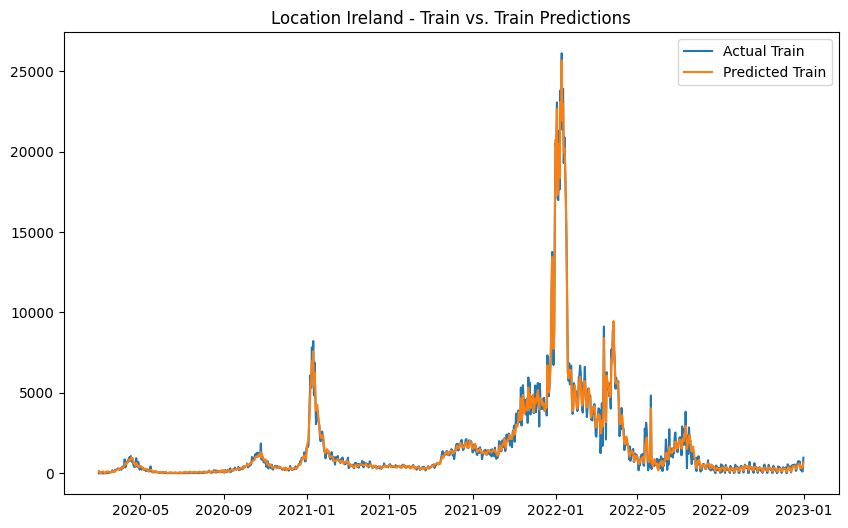

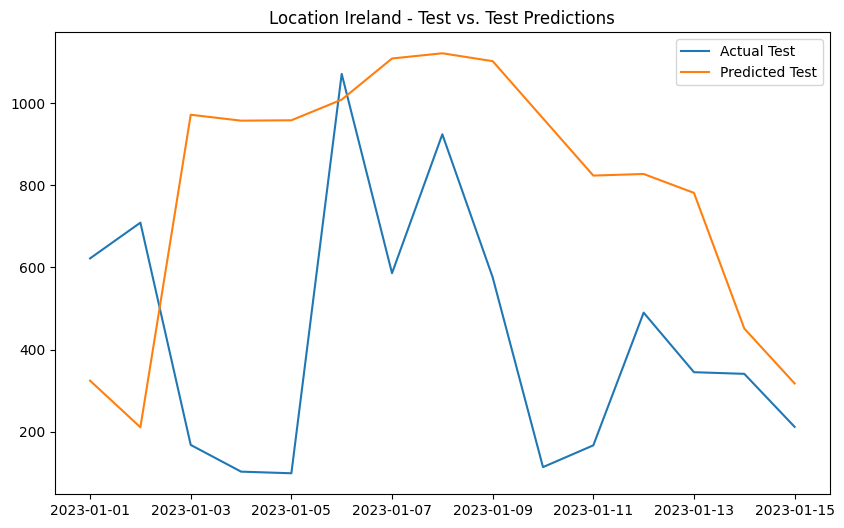

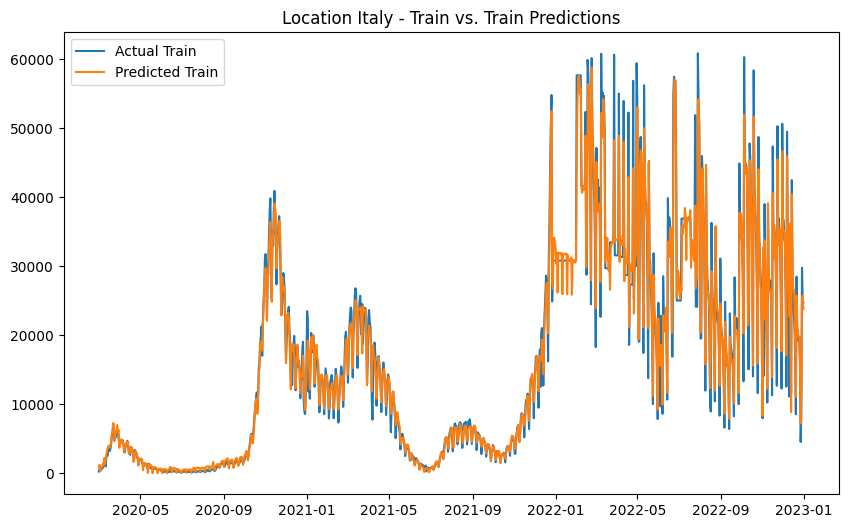

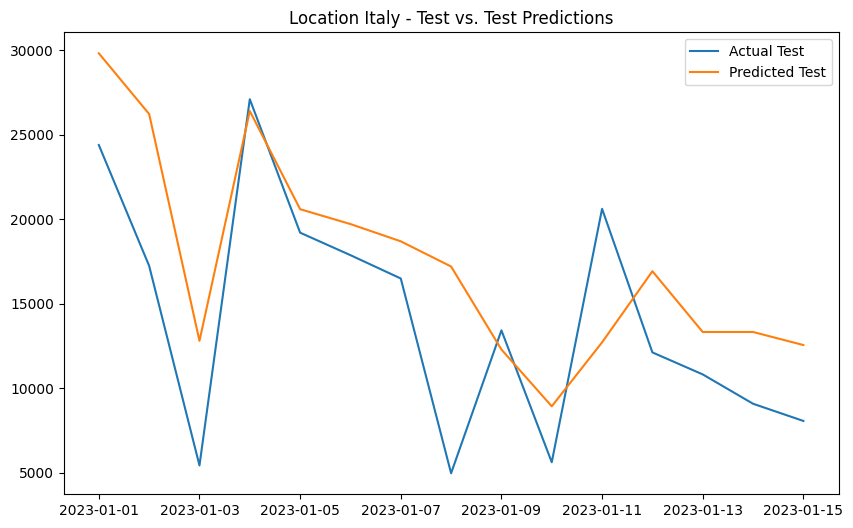

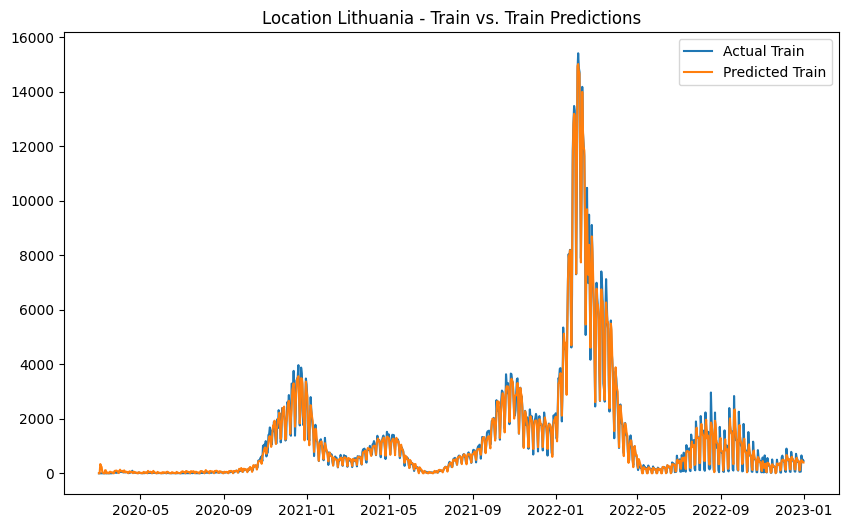

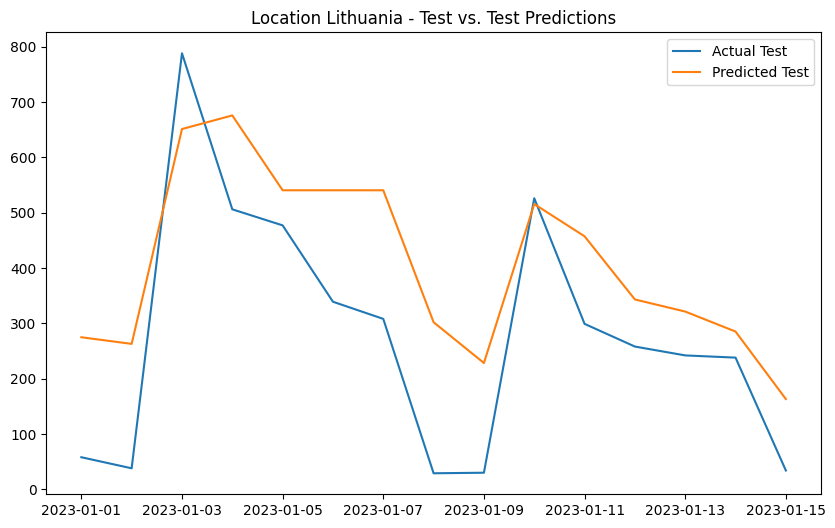

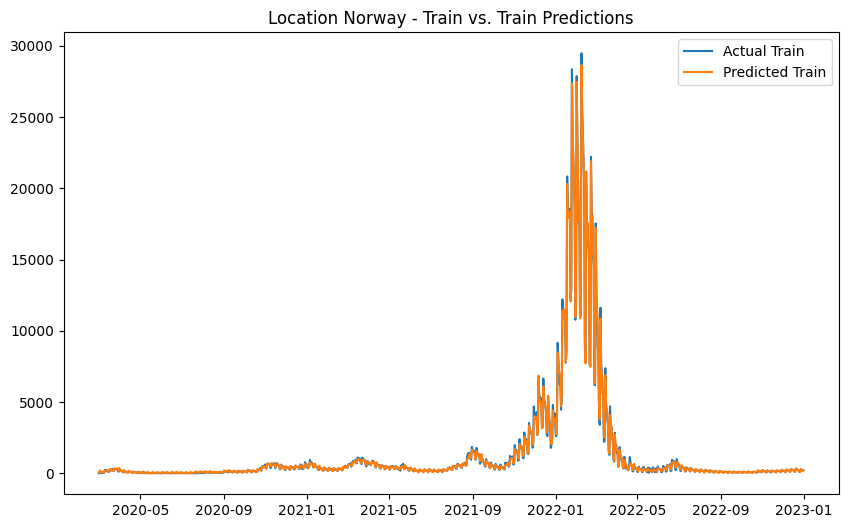

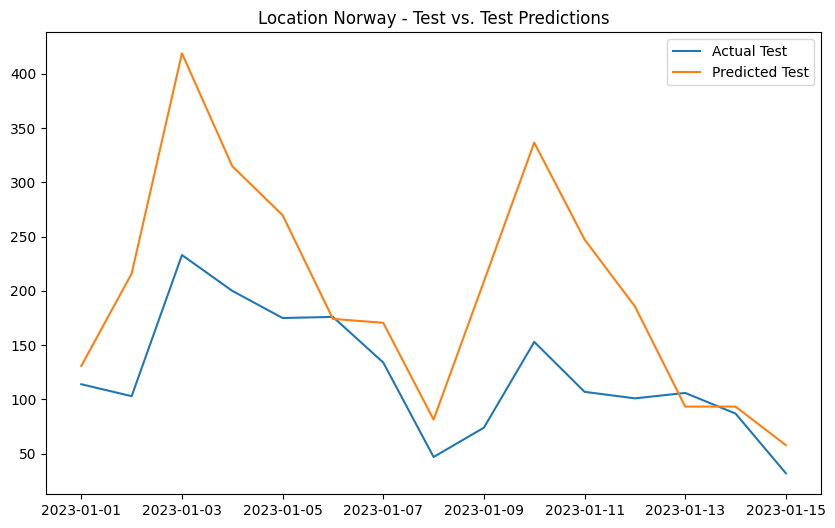

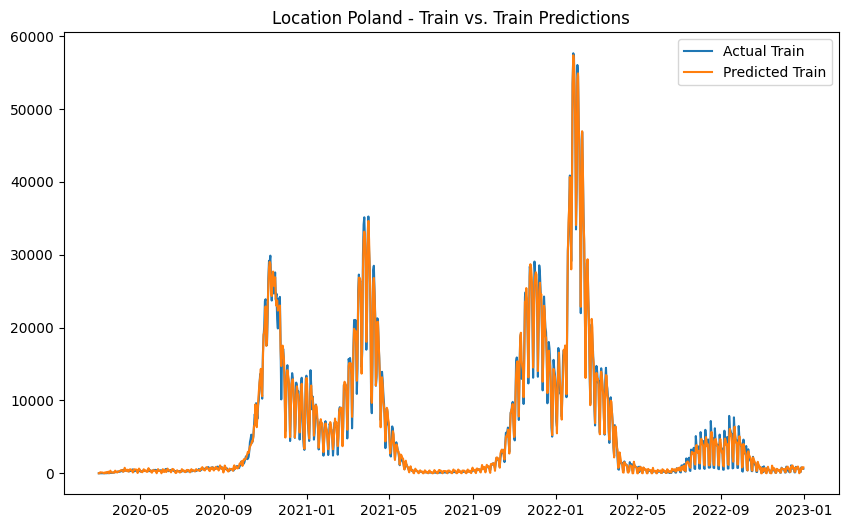

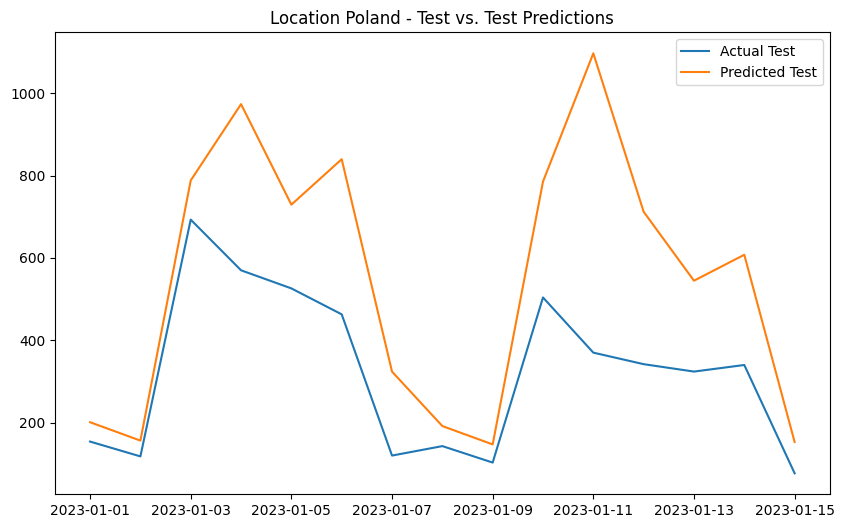

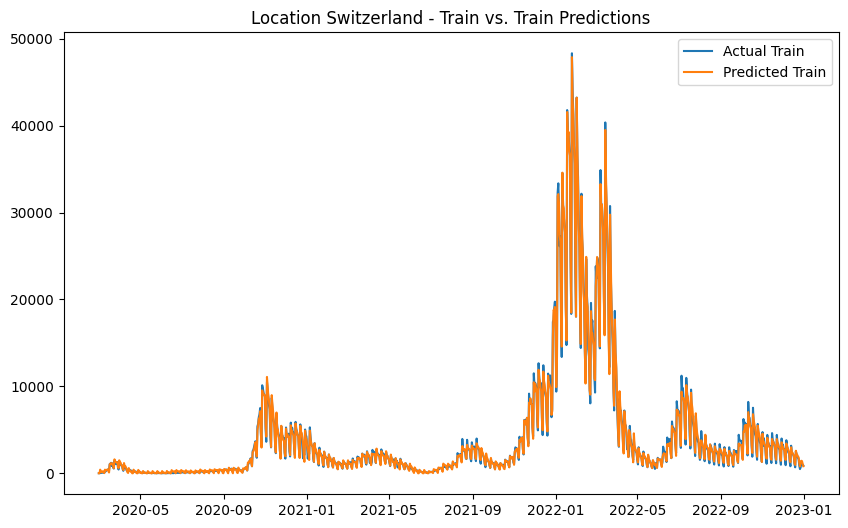

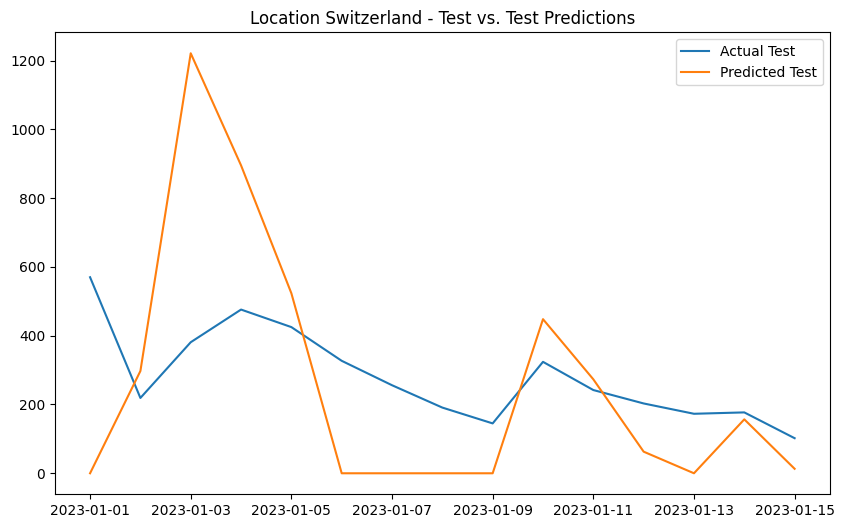

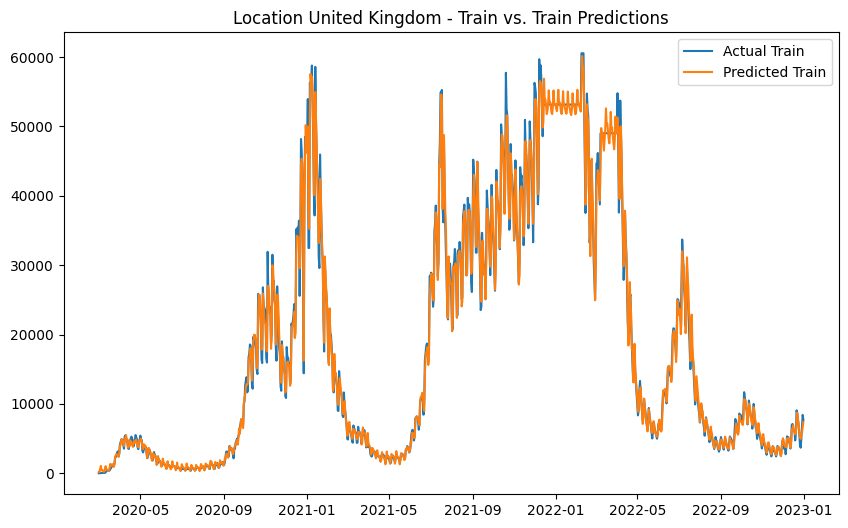

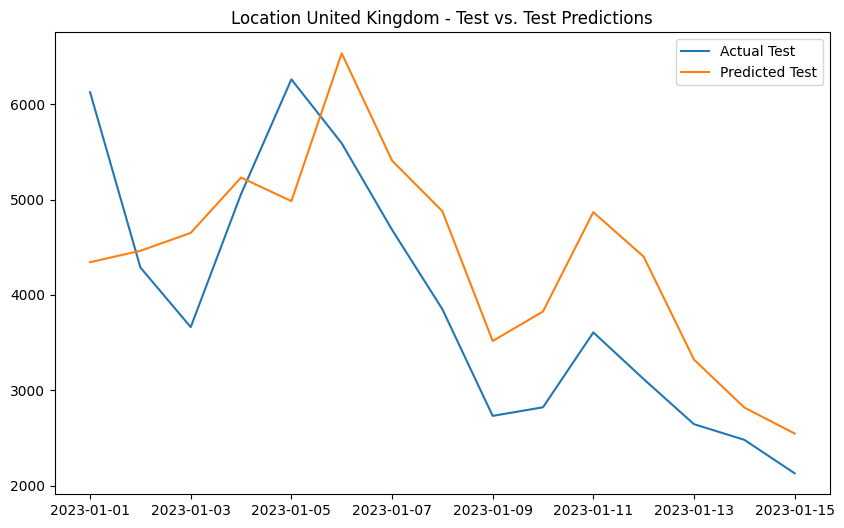

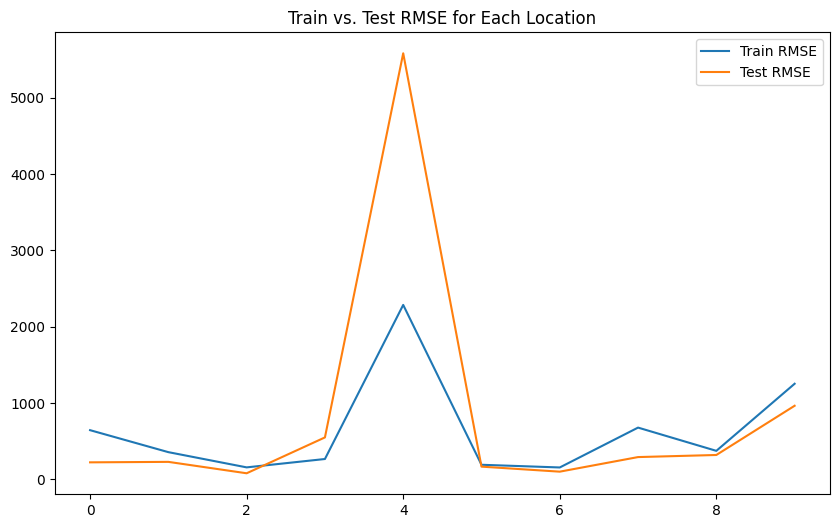

In [31]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Assuming your data is stored in a DataFrame named 'df' with columns 'target', 'location', and 'season'

# Print original unique locations
original_locations = data_prepped['location'].unique()
print("Original Unique Locations:", original_locations)

# Define X and y
X = data_prepped.drop(['new_cases', 'location'], axis=1)
y = data_prepped['new_cases']

# Encode locations and seasons
le_location = LabelEncoder()
X['location_encoded'] = le_location.fit_transform(data_prepped['location'])

le_season = LabelEncoder()
X['season'] = le_season.fit_transform(data_prepped['season'])

# Define the best parameters
best_params = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 0, 'subsample': 1.0}

# Initialize lists to store results
train_rmse_list = []
test_rmse_list = []
test_srmse_list = []

# Iterate over locations
for location in range(10):  # Assuming you have 10 locations
    location_mask = X['location_encoded'] == location
    X_location = X[location_mask]
    y_location = y[location_mask]

    # Calculate the number of observations for train and test sets
    num_obs = len(y_location)
    train_size = int(0.98667935 * num_obs)
    test_size = num_obs - train_size

    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_location, y_location, test_size=test_size, shuffle=False)

    # Initialize and fit the XGBoost model
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_pred[y_train_pred < 0] = 0
    y_test_pred[y_test_pred < 0] = 0

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_srmse = test_rmse / np.mean(y_test_pred) * 100

    # Append RMSE to lists
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    test_srmse_list.append(test_srmse)

    # Plot train vs. train predictions
    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, label='Actual Train')
    plt.plot(y_train.index, y_train_pred, label='Predicted Train')
    plt.title(f'Location {le_location.inverse_transform([location])[0]} - Train vs. Train Predictions')
    plt.legend()
    plt.show()

    # Plot test vs. test predictions
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual Test')
    plt.plot(y_test.index, y_test_pred, label='Predicted Test')
    plt.title(f'Location {le_location.inverse_transform([location])[0]} - Test vs. Test Predictions')
    plt.legend()
    plt.show()

# Plot overall train vs. test RMSE for each location
plt.figure(figsize=(10, 6))
plt.plot(train_rmse_list, label='Train RMSE')
plt.plot(test_rmse_list, label='Test RMSE')
plt.title('Train vs. Test RMSE for Each Location')
plt.legend()
plt.show()


In [33]:
# Create a DataFrame
xgb_results = pd.DataFrame({
    'Location': original_locations,
    'Train RMSE': train_rmse_list,
    'Test RMSE': test_rmse_list,
    'Standardized Test RMSE': test_srmse_list
})

# Print the resulting DataFrame
xgb_results


,Location,Train RMSE,Test RMSE,Standardized Test RMSE
0,Belgium,644.099184,222.644845,32.051020
1,Denmark,356.171553,228.840976,36.803729
2,Finland,156.723790,79.411698,47.085849
3,Ireland,266.345048,549.051145,69.053595
4,Italy,2284.766139,5580.917925,32.008864
5,Lithuania,190.813509,166.358726,40.898444
6,Norway,155.572317,100.600714,50.312809
7,Poland,677.696981,291.638049,53.019204
8,Switzerland,373.294854,319.010402,122.981992
9,United Kingdom,1252.124039,963.799342,21.976453


In [34]:
test_rmse_list

[222.64484535968813,
 228.84097617603157,
 79.4116976321024,
 549.0511445223477,
 5580.917925353786,
 166.35872623912198,
 100.60071382623737,
 291.6380491920198,
 319.0104016542872,
 963.7993420362795]